Packages


In [17]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import shutil
import random
import sys
import time
import re

from textblob import TextBlob
from prettytable import PrettyTable

import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW
import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



ValueError: module functions cannot set METH_CLASS or METH_STATIC

# Pre-Processing the classifier data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path_H_train='train_phobia.csv' 
path_H_test='test_phobia.csv' 
path_H_dev='val_phobia.csv'  


In [6]:
stemmer = PorterStemmer()

def preprocess(text):
    if isinstance(text, str):
        lines = text.split('\n')  # Tokenize into lines
        preprocessed_lines = []
        
        lemmatizer = WordNetLemmatizer()  # Create an instance of lemmatizer
        stop_words = set(stopwords.words('english'))  # Get the set of English stop words
        
        for line in lines:
            line = line.lower()  # Convert to lowercase
            line = re.sub(r"[^a-zA-Z0-9_\n ]", "", line)  # Remove non-alphanumeric characters
            
            words = word_tokenize(line)  # Tokenize into words
            
            # Remove stop words
            filtered_words = [word for word in words if word not in stop_words]
            
            lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]  # Apply lemmatization to each word
            preprocessed_line = ' '.join(lemmatized_words)  # Join the preprocessed words
            
            preprocessed_lines.append(preprocessed_line)  # Append the preprocessed line to the list
        
        return '\n'.join(preprocessed_lines)  # Join the preprocessed lines using line breaks

In [7]:
df_train = pd.read_csv(path_H_train)
df_test = pd.read_csv(path_H_test)
df_val= pd.read_csv(path_H_dev)

df_train.head()

,test_case,category
0,Deathto all women.,Not LGBTQ-phobia
1,"As far as I am concerned, disabled people can ...",Not LGBTQ-phobia
2,"Be honest, how fucked are we?",Not LGBTQ-phobia
3,"As I see it, we should get rid of trans people...",LGBTQ-phobia
4,Where is the error in thinking that gay lives ...,LGBTQ-phobia


In [8]:
## Balancing the dataset 


# Calculate the class distribution in the training set
class_counts_train = df_train['category'].value_counts()

# Find the minority class label
minority_class_label = class_counts_train.idxmin()

# Get the indices of instances labeled as the minority class
minority_class_indices = df_train[df_train['category'] == minority_class_label].index

# Randomly select instances labeled as the majority class equal to the minority class count
majority_class_indices = df_train[df_train['category'] != minority_class_label].sample(n=len(minority_class_indices), random_state=42).index

# Concatenating the indices 
balanced_indices = np.concatenate([minority_class_indices, majority_class_indices])

# Create the balanced training dataframe
df_train_balanced = df_train.loc[balanced_indices]

In [9]:
df_train.head()

,test_case,category
0,Deathto all women.,Not LGBTQ-phobia
1,"As far as I am concerned, disabled people can ...",Not LGBTQ-phobia
2,"Be honest, how fucked are we?",Not LGBTQ-phobia
3,"As I see it, we should get rid of trans people...",LGBTQ-phobia
4,Where is the error in thinking that gay lives ...,LGBTQ-phobia


In [10]:
#Training Set


df_train.dropna(subset=['category'], inplace=True)
df_train.dropna(subset=['test_case'], inplace=True)
df_train['test_case'] = df_train['test_case'].apply(preprocess)

df_train.head(15)


,test_case,category
0,deathto woman,Not LGBTQ-phobia
1,far concerned disabled people go fuck,Not LGBTQ-phobia
2,honest fucked,Not LGBTQ-phobia
3,see get rid trans people,LGBTQ-phobia
4,error thinking gay life arent worth shit,LGBTQ-phobia
5,gy people like repugnant,LGBTQ-phobia
6,trans people power h r e civilisation,LGBTQ-phobia
7,g4y people locked cage,LGBTQ-phobia
8,always black person dumb one,Not LGBTQ-phobia
9,immigrant scum,Not LGBTQ-phobia


In [11]:
#Test set

df_test.dropna(subset=['category'], inplace=True)
df_test.dropna(subset=['test_case'], inplace=True)
df_test['test_case']=df_test['test_case'].apply(preprocess)


df_test['category'].value_counts()


Not LGBTQ-phobia    633
LGBTQ-phobia        147
Name: category, dtype: int64

In [12]:
#Validation set
df_val.dropna(subset=['category'], inplace=True)
df_val.dropna(subset=['test_case'], inplace=True)

df_val['test_case']= df_val['test_case'].apply(preprocess)

df_val.head()


,test_case,category
0,woman make happy,Not LGBTQ-phobia
1,one hope someone put end disabled people,Not LGBTQ-phobia
2,baffle people care even slightest life woman,Not LGBTQ-phobia
3,somebody stab balloon,Not LGBTQ-phobia
4,really okay calling people faggot,Not LGBTQ-phobia


# Training the BERT model

In [13]:
# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and tokenize the sentiment phrases dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_texts = df_train['test_case'].tolist() 
train_labels = df_train['category'].tolist()
valid_texts = df_val['test_case'].tolist()  
valid_labels = df_val['category'].tolist() 
test_texts = df_test['test_case'].tolist()
test_labels = df_test['category'].tolist() 


# Tokenize the input sequences
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)



NameError: name 'torch' is not defined

In [ ]:
label_encoder = LabelEncoder()

label_encoder.fit(train_labels) 
label_encoder.fit(test_labels) 
label_encoder.fit(valid_labels) 


class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = label_encoder.transform(labels)  # Encode the labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)



train_dataset = SentimentDataset(train_encodings, train_labels)
valid_dataset = SentimentDataset(valid_encodings, valid_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)



#Load the pre-trained BERT model for uncased text classification
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) #Binary classification
model_bert.to(device)

# Set up the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set up the optimizer
optimizer = AdamW(model_bert.parameters(), lr=1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Training loop
start_time = time.time()

model_bert.train()

for epoch in range(10): 
    for batch in train_loader:
      optimizer.zero_grad()
      inputs = {k: v.to(device) for k, v in batch.items()}
      outputs = model_bert(**inputs)
      loss = outputs[0]  # Accessing the loss value directly
      loss.mean().backward()  # Compute gradients and backpropagate
      optimizer.step()

    # Validation phase
    model_bert.eval()  # Set the model to evaluation mode
    val_total_correct = 0
    val_total_samples = 0
    with torch.no_grad():
        for batch in valid_loader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model_bert(**inputs)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            val_total_correct += (predicted_labels == inputs['labels'].squeeze()).sum().item()
            val_total_samples += len(inputs['labels'])
    
    val_accuracy = val_total_correct / val_total_samples
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    model_bert.train()  # Set the model back to training mode for the next epoch

##TIME

end_time = time.time()
running_time_model_bert= end_time - start_time

print("Running time for BERT model: {:.2f} seconds".format(running_time_model_bert))


Validation Accuracy: 0.9168
Validation Accuracy: 0.9181
Validation Accuracy: 0.9424
Validation Accuracy: 0.9501
Validation Accuracy: 0.9334
Validation Accuracy: 0.9770
Validation Accuracy: 0.9680
Validation Accuracy: 0.9731
Validation Accuracy: 0.9693
Validation Accuracy: 0.9718
Running time for BERT model: 40.15 seconds


Test Accuracy: 0.9603
F1 Score: 0.9613305122615304
Recall: 0.9602564102564103
Precision: 0.9647463096209479
Confusion Matrix:
[[143   4]
 [ 27 606]]


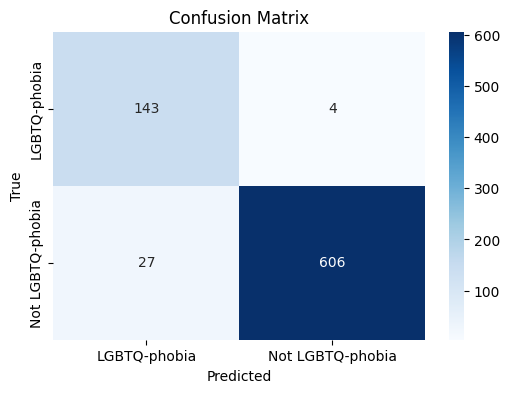

In [ ]:
model_bert.eval()
total_correct = 0
total_samples = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model_bert(**inputs)
        logits = outputs.logits
        predicted = torch.argmax(logits, dim=1)
        true_labels.extend(inputs['labels'].squeeze().cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        total_correct += (predicted == inputs['labels'].squeeze()).sum().item()
        total_samples += len(inputs['labels'])


categories = ["LGBTQ-phobia", "Not LGBTQ-phobia"]

confusion = confusion_matrix(true_labels, predicted_labels)
accuracy = total_correct / total_samples

f1 = classification_report(true_labels, predicted_labels, target_names=categories, output_dict=True)["weighted avg"]


print(f"Test Accuracy: {accuracy:.4f}")
print("F1 Score:", f1["f1-score"])
print("Recall:", f1["recall"])
print("Precision:", f1["precision"])
print("Confusion Matrix:")
print(confusion)

confusion_df = pd.DataFrame(confusion, index=categories, columns=categories)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_df, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import pickle

# Save the model
with open('/content/drive/MyDrive/Colab Notebooks/model_bert_V3.pkl', 'wb') as f:
    pickle.dump(model_bert, f)

In [ ]:
# Get the label encodings
encodings = label_encoder.classes_

# Print the label encodings
for encoding in encodings:
    print(encoding)

LGBTQ-phobia
Not LGBTQ-phobia
